In [207]:
import pandas as pd
import numpy as np

# File path
file_path = r"C:\Users\jiaju\Desktop\Final_data.xlsx"

# Load Sheet1
data = pd.read_excel(file_path, sheet_name="Sheet1")

In [210]:
 # drop rows with the same Date & Company, keep the first
df = data.drop_duplicates(subset=['Date', 'COMPANY'], keep='first')

In [211]:
### Pre-and post-covid 
# 2) Winsorize specified columns at the 1st and 99th percentile
to_winsor = [
    "Current ratio",
    "Interest coverage ratio",
    "ROA",
    "ROE",
    "Leverage ratio",
    "Market to book ratio",
    "Risk free rate",
    "CDS spread"
]

for col in to_winsor:
    q_low  = df[col].quantile(0.02)
    q_high = df[col].quantile(0.98)
    df[col] = df[col].clip(lower=q_low, upper=q_high)

# 3) Log-transform Total assets and Market value
for col in ["Total assets", "Market value"]:
    # if there’s a chance of zero or negative values, add a small constant:
    df["log_" + col.replace(" ", "_").lower()] = np.log(df[col].clip(lower=1e-6))

C:\Users\jiaju\AppData\Local\Temp\ipykernel_13204\3108312281.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].clip(lower=q_low, upper=q_high)
C:\Users\jiaju\AppData\Local\Temp\ipykernel_13204\3108312281.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].clip(lower=q_low, upper=q_high)
C:\Users\jiaju\AppData\Local\Temp\ipykernel_13204\3108312281.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [212]:
# 将 Date 列转换为日期格式
def parse_quarter(date_str):
    quarter, year = date_str.split()
    year = int(year)
    if quarter == 'Q1':
        return f'{year}-01-01'
    elif quarter == 'Q2':
        return f'{year}-04-01'
    elif quarter == 'Q3':
        return f'{year}-07-01'
    elif quarter == 'Q4':
        return f'{year}-10-01'
    return None

df['Date'] = pd.to_datetime(df['Date'].apply(parse_quarter), errors='coerce')
print("Date 列类型：", df['Date'].dtype)
print("Date 列前五行：\n", df['Date'].head())

Date 列类型： datetime64[ns]
Date 列前五行：
 0   2016-01-01
1   2016-04-01
2   2016-07-01
3   2016-10-01
4   2017-01-01
Name: Date, dtype: datetime64[ns]


C:\Users\jiaju\AppData\Local\Temp\ipykernel_13204\3421166255.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'].apply(parse_quarter), errors='coerce')


In [213]:
df = df.rename(columns=lambda x: x.strip().replace(" ", "_"))

In [23]:
print(df.columns)

Index(['ID', 'Date', 'Quarter', 'Year', 'COMPANY', 'Country', 'ISIN_CODE',
       'TICKER_SYMBOL', 'ICB_industry_name', 'ICB_sector_name', 'CDS_spread',
       'Community_Score', 'CSR_Strategy_Score', 'Emissions_Score',
       'Environment_Pillar_Score', 'Environmental_Innovation_Score',
       'ESG_Combined_Score', 'ESG_Controversies_Score', 'ESG_Score',
       'Governance_Pillar_Score', 'Human_Rights_Score', 'Management_Score',
       'Product_Responsibility_Score', 'Resource_Use_Score',
       'Shareholders_Score', 'Social_Pillar_Score',
       'TRDIR_Controversies_Score', 'TRDIR_Diversity_Score',
       'TRDIR_Inclusion_Score', 'TRDIR_People_Development_Score',
       'Workforce_Score', 'Book_value_per_share', 'Common_shares_outstanding',
       'Current_ratio', 'Interest_coverage_ratio',
       'Historical_volatility_5_years', 'Market_value', 'ROA', 'ROE',
       'Total_assets', 'Leverage_ratio', 'Market_to_book_ratio',
       'Risk_free_rate', 'Clause_dummy', 'Austria', 'Belgium'

In [214]:
from linearmodels.panel import PanelOLS
from statsmodels.iolib.summary2 import summary_col

# 1. Convert date to datetime if needed
df['Date'] = pd.to_datetime(df['Date'])

# 2. Set panel index
df = df.set_index(['COMPANY', 'Date'])

# 3. Independent variables (ESG pillars)
ivs = [
    'Environment_Pillar_Score',
    'Social_Pillar_Score',
    'Governance_Pillar_Score',
    'ESG_Controversies_Score'
]

# 4. Control variables
controls = [
    'Current_ratio', 'Interest_coverage_ratio', 'Historical_volatility_5_years',
    'Market_value', 'ROA', 'Leverage_ratio', 'Risk_free_rate',
    'Market_to_book_ratio', 'log_total_assets', 'log_market_value'
]


In [215]:
from linearmodels.panel import PanelOLS
from statsmodels.tools.tools import add_constant

# Step 1: Run models with one DV each time, keep results
models = []

for dv in ivs:
    formula = f'CDS_spread ~ 1 + {dv} + ' + ' + '.join(controls)
    mod = PanelOLS.from_formula(formula, data=df)
    res = mod.fit()
    models.append(res)


In [220]:
fe_tables = []

for name, result in zip(["Env Pillar", "Social Pillar", "Governance Pillar", "ESG Controversy"], models):
    # Extract main statistics
    summary_df = pd.DataFrame({
        'Coef.': result.params,
        'Std.Err': result.std_errors,
        'T-stat': result.tstats,
        'P-value': result.pvalues
    })

    # Compute Adjusted R² manually
    r2 = result.rsquared
    n = result.nobs
    k = len(result.params)
    r2_adj = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

    # Add bottom rows for R² and Adjusted R²
    extra_stats = pd.DataFrame({
        'Coef.': [r2, r2_adj],
        'Std.Err': ['', ''],
        'T-stat': ['', ''],
        'P-value': ['', '']
    }, index=['R-squared', 'Adj. R-squared'])

    summary_df = pd.concat([summary_df, extra_stats])

    # Add multi-indexed columns
    summary_df.columns = pd.MultiIndex.from_product([[name], summary_df.columns])
    fe_tables.append(summary_df)

# Combine all summaries
fe_summary_combined = pd.concat(fe_tables, axis=1)
pd.set_option('display.max_columns', None)
print(fe_summary_combined)

# Save to Excel
fe_summary_combined.to_excel("FE_model_FE_with_R2_adj.xlsx")


                               Env Pillar                                  \
                                    Coef.    Std.Err     T-stat   P-value   
Intercept                      418.932961  11.976716  34.978951       0.0   
Environment_Pillar_Score        -0.388677   0.054936  -7.075035       0.0   
Current_ratio                   -0.417595   1.357182  -0.307693   0.75832   
Interest_coverage_ratio         -0.260861   0.100316  -2.600406  0.009319   
Historical_volatility_5_years    4.749013   2.110612   2.250065  0.024457   
Market_value                     0.000056    0.00001   5.616563       0.0   
ROA                             -2.786645   0.222969 -12.497915       0.0   
Leverage_ratio                   0.000661   0.004207   0.157039  0.875216   
Market_to_book_ratio             0.480346   0.128428   3.740194  0.000184   
log_total_assets               -10.100870   1.164255  -8.675823       0.0   
log_market_value               -15.196167   1.160065 -13.099408       0.0   

In [219]:
re_tables = []

# Loop through each RE model result
for name, result in zip(["Env Pillar", "Social Pillar", "Governance Pillar", "ESG Controversy"], models):
    # Extract coefficients and related statistics
    summary_df = pd.DataFrame({
        'Coef.': result.params,
        'Std.Err': result.std_errors,
        'T-stat': result.tstats,
        'P-value': result.pvalues
    })

    # Compute Adjusted R² manually
    r2 = result.rsquared
    n = result.nobs
    k = len(result.params)
    r2_adj = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

    # Add R² and Adjusted R² at the bottom
    extra_stats = pd.DataFrame({
        'Coef.': [r2, r2_adj],
        'Std.Err': ['', ''],
        'T-stat': ['', ''],
        'P-value': ['', '']
    }, index=['R-squared', 'Adj. R-squared'])

    summary_df = pd.concat([summary_df, extra_stats])

    # Add multi-level column headers for readability
    summary_df.columns = pd.MultiIndex.from_product([[name], summary_df.columns])
    re_tables.append(summary_df)

# Combine all RE summaries horizontally
re_summary_combined = pd.concat(re_tables, axis=1)
pd.set_option('display.max_columns', None)
print(re_summary_combined)

# Save to Excel
re_summary_combined.to_excel("RE_model_summary_with_R2_adj.xlsx")


                               Env Pillar                                  \
                                    Coef.    Std.Err     T-stat   P-value   
Intercept                      418.932961  11.976716  34.978951       0.0   
Environment_Pillar_Score        -0.388677   0.054936  -7.075035       0.0   
Current_ratio                   -0.417595   1.357182  -0.307693   0.75832   
Interest_coverage_ratio         -0.260861   0.100316  -2.600406  0.009319   
Historical_volatility_5_years    4.749013   2.110612   2.250065  0.024457   
Market_value                     0.000056    0.00001   5.616563       0.0   
ROA                             -2.786645   0.222969 -12.497915       0.0   
Leverage_ratio                   0.000661   0.004207   0.157039  0.875216   
Market_to_book_ratio             0.480346   0.128428   3.740194  0.000184   
log_total_assets               -10.100870   1.164255  -8.675823       0.0   
log_market_value               -15.196167   1.160065 -13.099408       0.0   

In [221]:
import pandas as pd

# Replace this with your actual list of fitted OLS models
# ols_models = [ols_env, ols_soc, ols_gov, ols_contro]

ols_tables = []

for name, result in zip(["Env Pillar", "Social Pillar", "Governance Pillar", "ESG Controversy"], ols_models):
    summary_df = pd.DataFrame({
        'Coef.': result.params,
        'Std.Err': result.bse,
        'T-stat': result.tvalues,
        'P-value': result.pvalues
    })

    # Compute adjusted R² manually
    r2 = result.rsquared
    n = int(result.nobs)
    k = len(result.params)
    r2_adj = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

    # Append R² and adjusted R² as rows
    extra_stats = pd.DataFrame({
        'Coef.': [r2, r2_adj],
        'Std.Err': ['', ''],
        'T-stat': ['', ''],
        'P-value': ['', '']
    }, index=['R-squared', 'Adj. R-squared'])

    summary_df = pd.concat([summary_df, extra_stats])

    # Use MultiIndex for pretty column labels
    summary_df.columns = pd.MultiIndex.from_product([[name], summary_df.columns])
    ols_tables.append(summary_df)

# Combine all OLS summaries
ols_summary_combined = pd.concat(ols_tables, axis=1)

# Optional: print full table
pd.set_option('display.max_columns', None)
print(ols_summary_combined)

# Save to Excel
ols_summary_combined.to_excel("OLS_model_summary_with_R2_adj.xlsx")


NameError: name 'ols_models' is not defined

AttributeError: 'ellipsis' object has no attribute 'model'

In [178]:
from linearmodels.panel import PanelOLS

# 1. Define ESG IVs and control variables
ivs = [
    'Environment_Pillar_Score',
    'Social_Pillar_Score',
    'Governance_Pillar_Score',
    'ESG_Controversies_Score'
]

controls = [
    'Current_ratio', 'Interest_coverage_ratio', 'Historical_volatility_5_years',
    'Market_value', 'ROA', 'Leverage_ratio',
    'Market_to_book_ratio', 'log_total_assets', 'log_market_value'
]

# 2. Make sure panel index is set
df = df.set_index(['COMPANY', 'Date'])

# 3. Fit models
models = []  # this time, with real results
for iv in ivs:
    formula = f'CDS_spread ~ 1 + {iv} + ' + ' + '.join(controls)
    model = PanelOLS.from_formula(formula, data=df)
    result = model.fit()
    models.append(result)

KeyError: "None of ['COMPANY', 'Date'] are in the columns"

In [179]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

esg_names = ["Env Pillar", "Social Pillar", "Governance Pillar", "ESG Controversy"]
metrics = []

for name, result in zip(esg_names, models):
    y_true = result.model.dependent.dataframe.squeeze()
    y_pred = result.predict().fitted_values

    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = result.rsquared
    adj_r2 = 1 - ((1 - r2) * (result.nobs - 1) / (result.nobs - len(result.params) - 1))

    metrics.append({
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'R-squared': r2,
        'Adj. R-squared': adj_r2
    })

metrics_df = pd.DataFrame(metrics)
print(metrics_df)

               Model        RMSE         MAE  R-squared  Adj. R-squared
0         Env Pillar  179.629109  105.571040   0.081419        0.080070
1      Social Pillar  179.712739  105.559008   0.080563        0.079213
2  Governance Pillar  179.727141  105.613448   0.080416        0.079065
3    ESG Controversy  179.677641  105.592817   0.080923        0.079572


In [222]:
import pandas as pd
from linearmodels.panel import RandomEffects

# Container to store formatted results
re_tables = []

# Loop through each IV and label
for iv_name, label in zip(ivs, ["Env Pillar", "Social Pillar", "Governance Pillar", "ESG Controversy"]):
    formula = f'CDS_spread ~ 1 + {iv_name} + ' + ' + '.join(controls)
    model = RandomEffects.from_formula(formula, data=df)
    result = model.fit(cov_type='robust')

    # Extract stats
    coefs = result.params
    std_errs = result.std_errors
    t_stats = result.tstats
    p_vals = result.pvalues

    # Significance stars
    stars = []
    for p in p_vals:
        if p <= 0.01:
            stars.append('***')
        elif p <= 0.05:
            stars.append('**')
        elif p <= 0.1:
            stars.append('*')
        else:
            stars.append('')

    # Create formatted table
    summary_df = pd.DataFrame({
        'Coef.': [f"{c:.3f}{s}" for c, s in zip(coefs, stars)],
        'Std.Err': [f"{e:.3f}" for e in std_errs],
        'T-stat': [f"{t:.3f}" for t in t_stats],
        'P-value': [f"{p:.3f}" for p in p_vals]
    }, index=coefs.index)

    # Add R² and adjusted R²
    r2 = result.rsquared
    n = result.nobs
    k = len(coefs)
    r2_adj = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

    r2_df = pd.DataFrame({
        'Coef.': [f"{r2:.3f}", f"{r2_adj:.3f}"],
        'Std.Err': ['', ''],
        'T-stat': ['', ''],
        'P-value': ['', '']
    }, index=['R-squared', 'Adj. R-squared'])

    summary_df = pd.concat([summary_df, r2_df])

    # Set multi-column headers
    summary_df.columns = pd.MultiIndex.from_product([[label], summary_df.columns])
    re_tables.append(summary_df)

# Combine into one table
re_summary_combined = pd.concat(re_tables, axis=1)

# Output
pd.set_option('display.max_columns', None)
print(re_summary_combined)
re_summary_combined.to_excel("RE_model_summary_with_stderr_and_R2.xlsx")


                               Env Pillar                          \
                                    Coef. Std.Err  T-stat P-value   
Intercept                      192.714***  28.430   6.779   0.000   
Environment_Pillar_Score            0.085   0.058   1.462   0.144   
Current_ratio                   -6.796***   1.525  -4.457   0.000   
Interest_coverage_ratio           0.228**   0.095   2.412   0.016   
Historical_volatility_5_years     1.862**   0.912   2.042   0.041   
Market_value                        0.000   0.000   0.191   0.848   
ROA                             -1.533***   0.178  -8.598   0.000   
Leverage_ratio                      0.004   0.004   0.839   0.401   
Market_to_book_ratio               -0.017   0.140  -0.120   0.905   
log_total_assets                 7.023***   2.222   3.160   0.002   
log_market_value               -16.411***   1.969  -8.334   0.000   
R-squared                           0.020                           
Adj. R-squared                    

In [227]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels.panel import PanelOLS

# Simulated variable setup for demonstration
ivs = ["Environment_Pillar_Score", "Social_Pillar_Score", "Governance_Pillar_Score", "ESG_Controversies_Score"]
controls = [
    "current_ratio", "interest_coverage_ratio", "historical_volatility_5_years",
    "market_value", "roa", "roe", "total_assets", "leverage_ratio",
    "market_to_book_ratio", "risk_free_rate", "log_total_assets", "log_market_value"
]

# Placeholder DataFrame (this should be replaced with your actual df)
import numpy as np
np.random.seed(42)
df = pd.DataFrame({
    'Company': np.repeat(['A', 'B', 'C', 'D'], 10),
    'Date': list(range(10)) * 4,
    'CDS_spread': np.random.rand(40) * 100,
    'Environment_Pillar_Score': np.random.rand(40) * 100,
    'Social_Pillar_Score': np.random.rand(40) * 100,
    'Governance_Pillar_Score': np.random.rand(40) * 100,
    'ESG_Controversies_Score': np.random.rand(40) * 100,
    'current_ratio': np.random.rand(40) * 2,
    'interest_coverage_ratio': np.random.rand(40) * 10,
    'historical_volatility_5_years': np.random.rand(40) * 30,
    'market_value': np.random.rand(40) * 1e6,
    'roa': np.random.rand(40),
    'roe': np.random.rand(40),
    'total_assets': np.random.rand(40) * 1e7,
    'leverage_ratio': np.random.rand(40),
    'market_to_book_ratio': np.random.rand(40),
    'risk_free_rate': np.random.rand(40),
    'log_total_assets': np.log1p(np.random.rand(40) * 1e7),
    'log_market_value': np.log1p(np.random.rand(40) * 1e6)
})
df = df.set_index(['Company', 'Date'])

# Container to store formatted results
fe_tables = []

# Loop through IVs to estimate Fixed Effects models
for iv_name, label in zip(ivs, ["Env Pillar", "Social Pillar", "Governance Pillar", "ESG Controversy"]):
    formula = f'CDS_spread ~ 1 + {iv_name} + ' + ' + '.join(controls)
    model = PanelOLS.from_formula(formula, data=df)
    result = model.fit(cov_type='robust')

    # Format coefficients with significance stars
    stars = []
    for p in result.pvalues:
        if p <= 0.01:
            stars.append('***')
        elif p <= 0.05:
            stars.append('**')
        elif p <= 0.1:
            stars.append('*')
        else:
            stars.append('')

    coef_with_stars = [f"{coef:.3f}{star}" for coef, star in zip(result.params, stars)]
    coef_df = pd.DataFrame(coef_with_stars, index=result.params.index, columns=[label])

    # Calculate Adjusted R²
    r2 = result.rsquared
    n = result.nobs
    k = len(result.params)
    r2_adj = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

    # Append R² and Adjusted R² to table
    r2_df = pd.DataFrame({label: [f"{r2:.3f}", f"{r2_adj:.3f}"]}, index=['R-squared', 'Adj. R-squared'])
    coef_df = pd.concat([coef_df, r2_df])

    fe_tables.append(coef_df)

# Combine all models side-by-side
fe_summary_combined = pd.concat(fe_tables, axis=1)

# Save to Excel
fe_summary_combined.to_excel("FE_model_summary_with_stars_R2.xlsx")

 


In [91]:
from linearmodels.panel import PanelOLS, RandomEffects

 

# Common formula
formula = 'CDS_spread ~ 1 + Social_Pillar_Score + ' + ' + '.join([
    'Current_ratio', 'Interest_coverage_ratio', 'Historical_volatility_5_years',
    'Market_value', 'ROA', 'ROE', 'Total_assets', 'Leverage_ratio',
    'Market_to_book_ratio', 'Risk_free_rate'
])

# Fit FE model
fe_model = PanelOLS.from_formula(formula, data=df)
fe_res = fe_model.fit(cov_type='robust')

# Fit RE model
re_model = RandomEffects.from_formula(formula, data=df)
re_res = re_model.fit(cov_type='robust')

# Run the Hausman test
comparison = compare({'FE': fe_res, 'RE': re_res})
print(comparison)


                      Model Comparison                      
                                          FE              RE
------------------------------------------------------------
Dep. Variable                     CDS_spread      CDS_spread
Estimator                           PanelOLS   RandomEffects
No. Observations                       18000           18000
Cov. Est.                             Robust          Robust
R-squared                             0.0433          0.0172
R-Squared (Within)                   -0.0273          0.0176
R-Squared (Between)                   0.0652          0.0052
R-Squared (Overall)                   0.0433          0.0081
F-statistic                           74.043          28.682
P-value (F-stat)                      0.0000          0.0000
=============================== ============ ===============
Intercept                             188.12          104.72
                                    (22.041)        (10.535)
Social_Pillar_Score     

In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import shap
from linearmodels.panel import PanelOLS, RandomEffects
from sklearn.inspection import PartialDependenceDisplay
import os
import warnings
from scipy import stats
from statsmodels.regression.quantile_regression import QuantReg
# Load Sheet1
 

In [204]:
# ESG 波动性分析
print("\n### ESG 波动性分析 ###")
esg_columns = [col for col in feature_names if 'Score' in col]
data['ESG_Volatility'] = data[esg_columns].std(axis=1)
features_with_vol = pd.concat([features, data['ESG_Volatility']], axis=1)
scaler_with_vol = StandardScaler()
features_scaled_with_vol = scaler_with_vol.fit_transform(features_with_vol)
X_train_with_vol, X_test_with_vol, y_train, y_test = train_test_split(features_scaled_with_vol, target, test_size=0.2, random_state=42)
rf_with_vol = RandomForestRegressor(**rf_grid.best_params_, random_state=42, n_jobs=-1)
rf_with_vol.fit(X_train_with_vol, y_train)
rf_r2_with_vol = rf_with_vol.score(X_test_with_vol, y_test)
print(f"加入 ESG 波动性后的随机森林 R² (测试集): {rf_r2_with_vol:.4f}")

# 识别影响最大的 ESG 子评分
print("\n### 识别影响最大的 ESG 子评分 ###")
esg_sub_scores = [col for col in feature_names if 'Score' in col]
shap_esg = pd.DataFrame(shap_values, columns=feature_names)[esg_sub_scores].abs().mean().sort_values(ascending=False)
print("SHAP 值分析：影响最大的 ESG 子评分（前5个）：")
print(shap_esg.head(5))


### ESG 波动性分析 ###


NameError: name 'rf_grid' is not defined

In [205]:
# 选择特征和目标变量
exclude_cols = ['CDS spread', 'ID', 'Date', 'Quarter', 'Year', 'COMPANY', 'Country',
                'ISIN CODE', 'TICKER SYMBOL', 'ICB industry name', 'ICB sector name']
features = data.drop(columns=exclude_cols)
target = data['CDS spread']

# 移除国家虚拟变量和行业虚拟变量
country_dummies = [col for col in features.columns if col in ['AUSTRIA', 'BELGIUM', 'CZECH_REPUBLIC', 'DENMARK',
                                                             'FINLAND', 'FRANCE', 'GERMANY', 'GREECE', 'ITALY',
                                                             'NETHERLANDS', 'NORWAY', 'PORTUGAL', 'SPAIN', 'SWEDEN',
                                                             'SWITZERLAND', 'UNITED_KINGDOM', 'UNITED_STATES']]
industry_dummies = [col for col in features.columns if col in ['Basic_Materials', 'Consumer_Discretionary',
                                                               'Consumer_Staples', 'Energy', 'Financials',
                                                               'Health_Care', 'Industrials', 'Real_Estate',
                                                               'Technology', 'Telecommunications', 'Utilities']]
features = features.drop(columns=country_dummies + industry_dummies)
print(f"调试信息：国家虚拟变量: {country_dummies}")
print(f"调试信息：行业虚拟变量: {industry_dummies}")
print(f"调试信息：保留的特征: {features.columns.tolist()}")

# 标准化特征
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
feature_names = features.columns

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)
print(f"训练集大小: {X_train.shape}, 测试集大小: {X_test.shape}")


调试信息：国家虚拟变量: []
调试信息：行业虚拟变量: []
调试信息：保留的特征: ['Community Score', 'CSR Strategy Score', 'Emissions Score', 'Environment Pillar Score', 'Environmental Innovation Score', 'ESG Combined Score', 'ESG Controversies Score', 'ESG Score', 'Governance Pillar Score', 'Human Rights Score', 'Management Score', 'Product Responsibility Score', 'Resource Use Score', 'Shareholders Score', 'Social Pillar Score', 'TRDIR Controversies Score', 'TRDIR Diversity Score', 'TRDIR Inclusion Score', 'TRDIR People Development Score', 'Workforce Score', 'Book value per share', 'Common shares outstanding', 'Current ratio', 'Interest coverage ratio', 'Historical volatility 5 years', 'Market value', 'ROA', 'ROE', 'Total assets', 'Leverage ratio', 'Market to book ratio', 'Risk free rate', 'ESG_Volatility']
训练集大小: (4694, 33), 测试集大小: (1174, 33)



### XGBoost 模型 ###
最佳参数: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
XGBoost R² (测试集): 0.9890


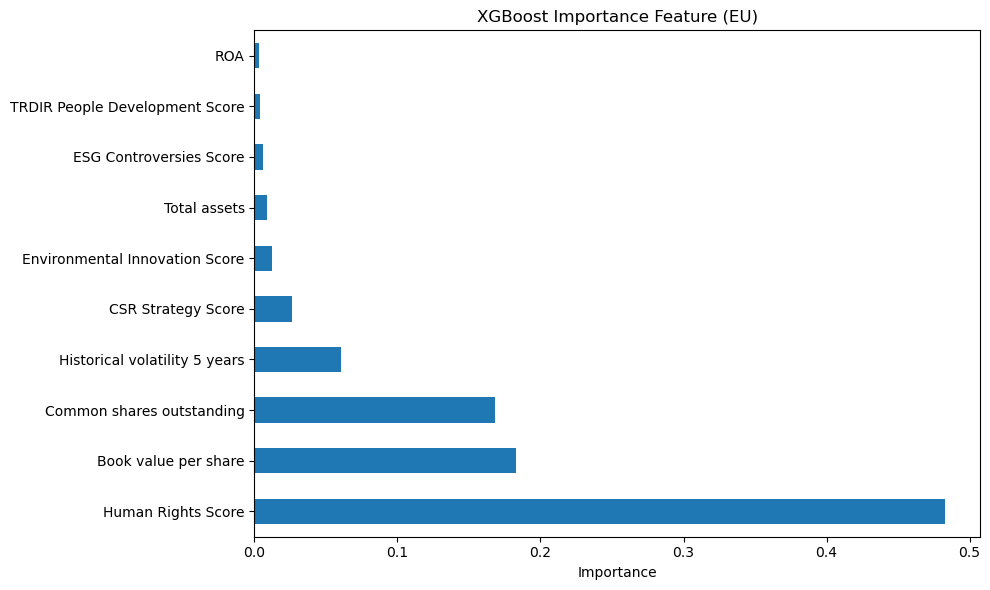

In [206]:
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
# XGBoost（超参数调优）
print("\n### XGBoost 模型 ###")
xgb_param_grid = {'n_estimators': [100, 200], 'max_depth': [5, 10], 'learning_rate': [0.05, 0.1]}
xgb_grid = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
                        xgb_param_grid, cv=5, scoring='r2')
xgb_grid.fit(X_train, y_train)
print("最佳参数:", xgb_grid.best_params_)
xgb_model = xgb_grid.best_estimator_
xgb_r2 = xgb_model.score(X_test, y_test)
print(f"XGBoost R² (测试集): {xgb_r2:.4f}")

# XGBoost 特征重要性图
xgb_importance = pd.Series(xgb_model.feature_importances_, index=feature_names).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
xgb_importance.head(10).plot(kind='barh')
plt.title('XGBoost Importance Feature (EU)')
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig('XGboost_EU.png')
plt.show()



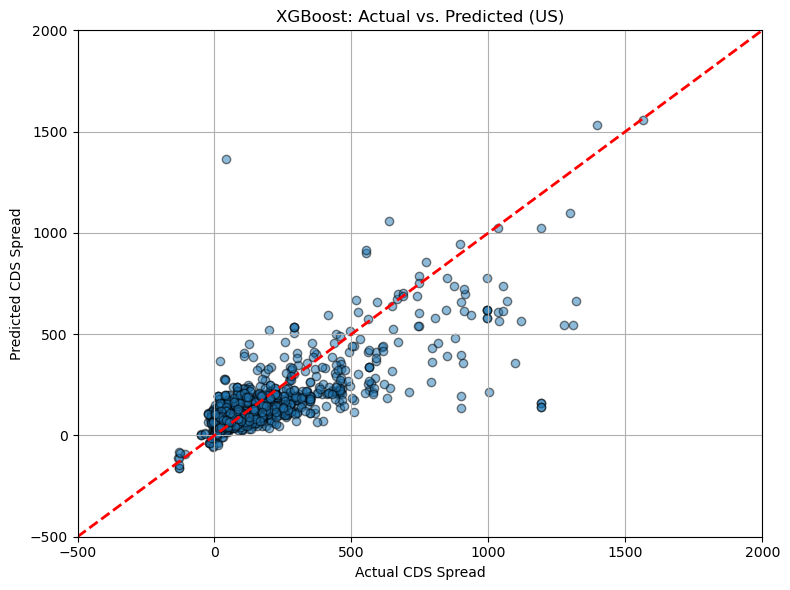

In [197]:
# Predict using XGBoost
y_pred_xgb = xgb_model.predict(X_test)
# Plot: Actual vs. Predicted with zoom
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5, edgecolors='k')
plt.plot([-500, 2000], [-500, 2000], 'r--', linewidth=2)  # 45° reference line with zoom range
plt.xlim(-500, 2000)
plt.ylim(-500, 2000)
plt.xlabel("Actual CDS Spread")
plt.ylabel("Predicted CDS Spread")
plt.title("XGBoost: Actual vs. Predicted (US)")
plt.grid(True)
plt.tight_layout()
plt.savefig("xgboost_US_actual_vs_predicted.png", dpi=300)
plt.show()